In [1]:
# --- Imports
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Model imports
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# --- Settings
sns.set_theme(style='whitegrid')
np.random.seed(42)

In [2]:
def bootstrap(n, X_train, X_test, z_train, z_test, pipeline): # as in lecture notes
    z_pred = np.empty((z_test.shape[0], n))
    for i in range(n):
        x_, y_ = resample(X_train, z_train) # bootstrap from sklearn.utils

        # Evaluate the new model on the same test data each time
        z_pred[:, i] = pipeline.fit(x_, y_).predict(X_test).ravel()

    return z_pred

We load in the data and create a meshgrid of points used for predicting the values

In [3]:
# loading a numpy-array containing the topological data
z = np.load('topological_data_Ottadalen.npy')[4650:4900, 800:1050]

# --- Generating dataset
n = 250 # the square root of the number of datapoints
x, y = np.linspace(0,n,n), np.linspace(0, n, n)
x, y = np.meshgrid(x, y)
x = x.ravel()
y = y.ravel()

z = z.ravel()

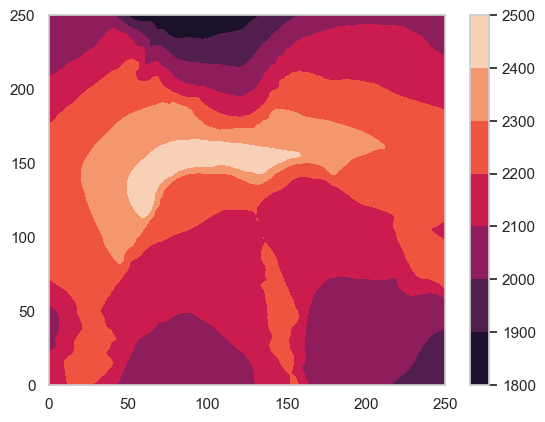

In [35]:
a = plt.contourf(x,y,z)
plt.colorbar(a)

## OLS

In [4]:
n_bootstrap = 50
k_folds = 10

# --- Creating design matrix
p = 5 # highest polynomial degree
N = np.arange(p+1) # for looping
L = [int((p+1)*(p+2)/2) for p in N] # beta lengths for plotting later
l = L[-1] # greatest beta length

# --- Loop
MSE_train, MSE_test = np.zeros(p), np.zeros(p)
R2_train, R2_test = np.zeros(p), np.zeros(p)
beta_values = np.zeros((p, l))

for i, ex_p in enumerate(N[1:]): 
    # Splitting the data 
    X = np.column_stack((x,y)) # design matrix
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=3)
    
    pipeline = make_pipeline(
            PolynomialFeatures(degree=ex_p),
            StandardScaler(),
            LinearRegression())
    
    # Estimating mse with k-fold on train data
    estimated_mse_folds = cross_val_score(estimator=pipeline, X=X_train, y=z_train, scoring='neg_mean_squared_error', cv=k_folds)
    estimated_mse_sklearn = np.mean(np.abs(estimated_mse_folds))
    
    # --- Fitting our model to our train-dataset and predicting values from both test and train
    pipeline.fit(X_train, z_train)
    z_tilde = pipeline.predict(X_train)
    z_predict = pipeline.predict(X_test)
    
    # Standard metrics
    MSE_train[i] = mean_squared_error(z_train, z_tilde)
    MSE_test[i] = mean_squared_error(z_test, z_predict)
    R2_train[i] = r2_score(z_train, z_tilde)
    R2_test[i] = r2_score(z_test, z_predict)
    print(f"The k-fold estimated MSE is {estimated_mse_sklearn:.4f}. The real MSE on the test data was {MSE_test[i]:.4f}")

    # Retrieving the beta-values
    intercept = pipeline.named_steps['linearregression'].intercept_
    coefs = pipeline.named_steps['linearregression'].coef_
    beta_values[i, :len(coefs)] = coefs

    # --- Estimating the variance of the best model with bootstrap
    z_bootstrap = bootstrap(n_bootstrap, X_train, X_test, z_train, z_test, pipeline)
    z_test = z_test.reshape(-1,1) # casting to 2D column
    
    error = np.mean( np.mean((z_test - z_bootstrap)**2, axis=1, keepdims=True) )
    bias = np.mean((z_test - np.mean(z_bootstrap, axis=1, keepdims=True))**2)
    variance = np.mean(np.var(z_bootstrap, axis=1, keepdims=True) )
    print(rf"The error, squared bias and variance of OLS (degree {i+1}) is {error:.4f} >= {bias:.4f} + {variance:.4f}, in order. Beware of rounding errors!")
    print('-'*50) # separator


The k-fold estimated MSE is 12256.6898. The real MSE on the test data was 12346.7543
The error, squared bias and variance of OLS (degree 1) is 12347.2681 >= 12346.6233 + 0.6448, in order. Beware of rounding errors!
--------------------------------------------------
The k-fold estimated MSE is 5719.7272. The real MSE on the test data was 5689.9183
The error, squared bias and variance of OLS (degree 2) is 5690.3095 >= 5689.7521 + 0.5574, in order. Beware of rounding errors!
--------------------------------------------------
The k-fold estimated MSE is 3794.6241. The real MSE on the test data was 3751.2198
The error, squared bias and variance of OLS (degree 3) is 3752.0972 >= 3751.3341 + 0.7631, in order. Beware of rounding errors!
--------------------------------------------------
The k-fold estimated MSE is 3505.0855. The real MSE on the test data was 3480.3613
The error, squared bias and variance of OLS (degree 4) is 3481.1362 >= 3480.2775 + 0.8587, in order. Beware of rounding errors!

In [22]:
df = pd.DataFrame(beta_values, index=list(range(1,6)))
df.insert(21, "MSE_train", MSE_train)
df.insert(22, "MSE_test", MSE_test)
df.insert(23, "R2_train", R2_train)
df.insert(24, "R2_test", R2_test)
df.to_csv('OLS_5_values.csv', index=False)

### Plotting the MSE and R2-score

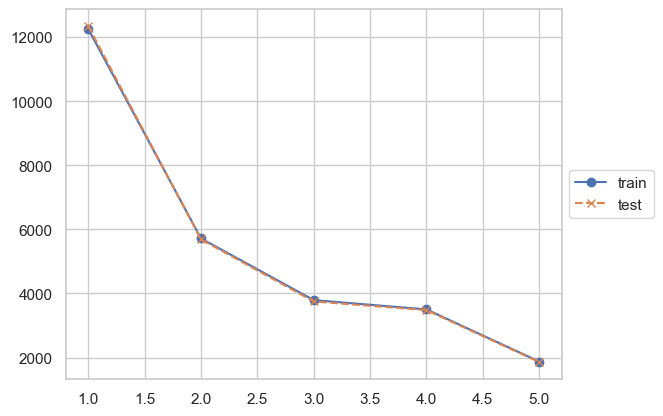

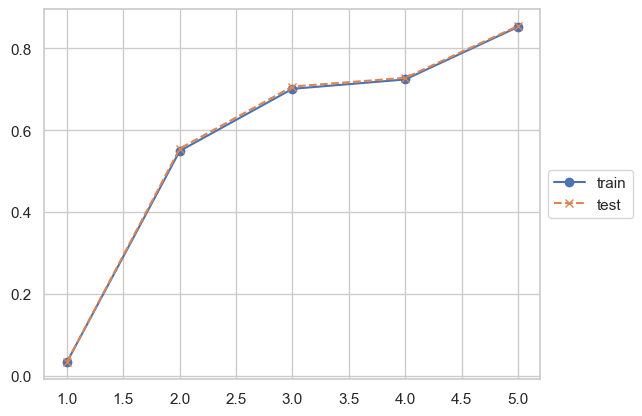

In [5]:
# Plotting MSE and R2 against complexity
plt.plot(N[1:], MSE_train, 'o-', label='train')
plt.plot(N[1:], MSE_test, 'x--', label='test')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True)
plt.show()

plt.plot(N[1:],R2_train, 'o-', label='train')
plt.plot(N[1:],R2_test, 'x--', label='test')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True)
plt.show()

### Plotting the topological data

Using the (currently last fitted model) to predict the entire dataset

In [6]:
z_total = pipeline.predict(X)

x_plot = x.reshape((n,n))
y_plot = y.reshape((n,n))
z_plot = z_total.reshape((n,n))

z_orig_plot = z.reshape((n,n))

Plotting the results in a 3D-plot

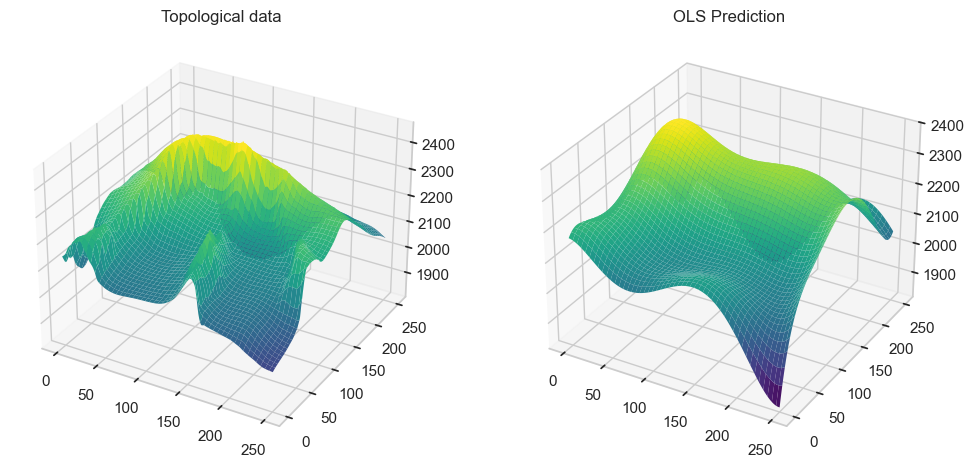

In [7]:
fig = plt.figure(figsize=(12, 6))

# Plotting the datapoints
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x_plot, y_plot, z_orig_plot, cmap='viridis', edgecolor='none')
ax.set_title('Topological data')

# Plot the polynomial regression prediction (ideally a plane)
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x_plot, y_plot, z_plot, cmap='viridis', edgecolor='none')
ax.set_title('OLS Prediction')

plt.show()

Plotting the results as a contour-plot

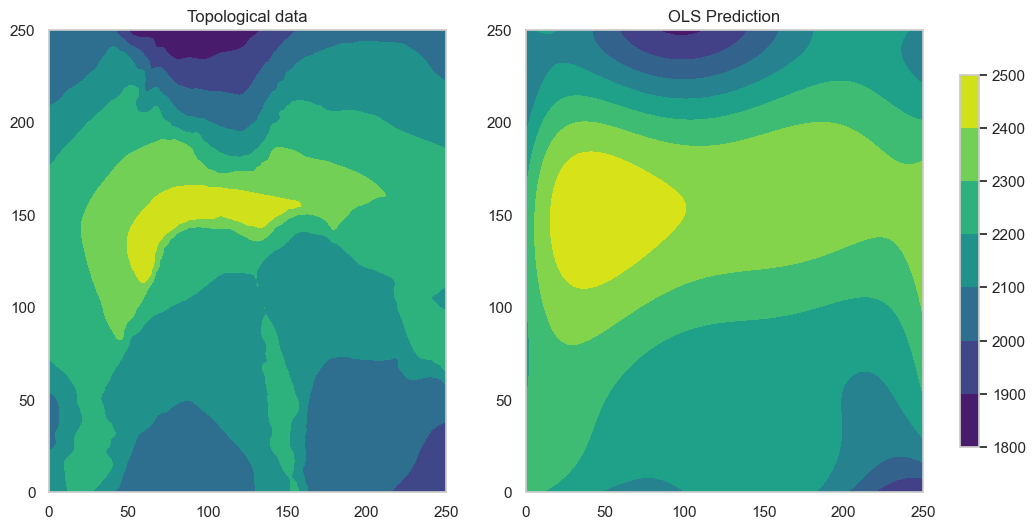

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the datapoints
original_data = axs[0].contourf(x_plot, y_plot, z_orig_plot, cmap='viridis')
axs[0].set_title('Topological data')

# Plot the polynomial regression prediction
fitted_data = axs[1].contourf(x_plot, y_plot, z_plot, cmap='viridis')
axs[1].set_title('OLS Prediction')


# Create the colorbar
contourf_objects = [original_data, fitted_data]
fig.colorbar(contourf_objects[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

plt.show()

## Ridge

In [9]:
n_bootstrap = 50
k_folds = 10
estimated_mse_sklearn = np.empty(p)

p = 5 # highest polynomial degree minus 1 
N = np.arange(p+1) # for looping and plotting later
L = [int((p+1)*(p+2)/2) for p in N+1] # beta lengths
l = L[-1] # greatest beta length

logmin, logmax, m = -4, 0, 5 # logspace start, end, number of lambda values
llambdas = np.logspace(logmin, logmax, m)

beta_values = np.zeros((p+1, l+1, m))
MSE_train, MSE_test = np.zeros((p+1, m)), np.zeros((p+1, m))
R2_train, R2_test = np.zeros((p+1, m)), np.zeros((p+1, m))

for i in N:
    # we stack the values of x and y beside each other
    X = np.column_stack((x,y))

    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=3)

    for j, lmb in enumerate(llambdas):
        pipeline = make_pipeline(
            PolynomialFeatures(degree=i+1),
            StandardScaler(),
            Ridge(alpha=lmb)
            )
        estimated_mse_folds = cross_val_score(estimator=pipeline, X=X_train, y=z_train, scoring='neg_mean_squared_error', cv=k_folds)
        
        # cross_val_score returns an array containing the estimated negative mse for every fold
        # taking the mean across all folds gives an estimate of the mse of the model
        estimated_mse_sklearn[j] = np.mean(np.abs(estimated_mse_folds))

        pipeline.fit(X_train,z_train)
        z_tilde = pipeline.predict(X_train)
        z_predict = pipeline.predict(X_test)
        intercept = pipeline.named_steps['ridge'].intercept_
        coefs = pipeline.named_steps['ridge'].coef_

        # --- Standard measurments for each model
        MSE_train[i-1,j], MSE_test[i-1,j] = mean_squared_error(z_tilde, z_train), mean_squared_error(z_predict, z_test)
        R2_train[i-1,j], R2_test[i-1,j] = r2_score(z_tilde, z_train), r2_score(z_predict, z_test)

        beta_values[i,0,j] = intercept
        beta_values[i,1:len(coefs)+1,j] = coefs
    
    min_mse_idx = np.argmin(estimated_mse_sklearn)
    best_lmb = llambdas[min_mse_idx]

    print(f"The k-fold estimated MSE on the best model of degree {i+1} (lambda = {lmb}) is {estimated_mse_sklearn[j]:.4f}. The real MSE on the test data was {MSE_test[i-1,j]:.4f}")
    

    # --- Estimating the variance of the best model with bootstrap
    pipeline = make_pipeline(
            PolynomialFeatures(degree=i+1),
            StandardScaler(),
            Ridge(alpha=best_lmb)
            )
    # --- Estimating the variance of the best model with bootstrap
    z_bootstrap = bootstrap(n_bootstrap, X_train, X_test, z_train, z_test, pipeline)
    z_test = z_test.reshape(-1,1) # casting to 2D column
    
    error = np.mean( np.mean((z_test - z_bootstrap)**2, axis=1, keepdims=True) )
    bias = np.mean((z_test - np.mean(z_bootstrap, axis=1, keepdims=True))**2)
    variance = np.mean(np.var(z_bootstrap, axis=1, keepdims=True) )
    print(rf"The error, squared bias and variance of the best model of degree {i+1} (lambda = {best_lmb}) is {error:.4f} >= {bias:.4f} + {variance:.4f}, in order. Beware of rounding errors!")
    print('-'*50) # separator


The k-fold estimated MSE on the best model of degree 1 (lambda = 1.0) is 12256.6898. The real MSE on the test data was 12346.7543
The error, squared bias and variance of the best model of degree 1 (lambda = 1.0) is 12346.9383 >= 12346.1647 + 0.7736, in order. Beware of rounding errors!
--------------------------------------------------
The k-fold estimated MSE on the best model of degree 2 (lambda = 1.0) is 5719.7298. The real MSE on the test data was 5689.9629
The error, squared bias and variance of the best model of degree 2 (lambda = 0.01) is 5690.5371 >= 5689.9233 + 0.6138, in order. Beware of rounding errors!
--------------------------------------------------
The k-fold estimated MSE on the best model of degree 3 (lambda = 1.0) is 3794.9128. The real MSE on the test data was 3751.1856
The error, squared bias and variance of the best model of degree 3 (lambda = 0.01) is 3751.9119 >= 3751.1579 + 0.7540, in order. Beware of rounding errors!
-------------------------------------------

In [ ]:
# plotting best fit, which is the final pipeline

# Lazzooo

In [12]:
import os
import warnings
import sys

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [13]:
n_bootstrap = 50
k_folds = 10

p = 5 # highest polynomial degree minus one
N = np.arange(p+1) # for looping and plotting later
L = [int((p+1)*(p+2)/2) for p in N+1] # beta lengths
l = L[-1] # greatest beta length

logmin, logmax, m = -4, 0, 5 # logspace start, end, number of lambda values
llambdas = np.logspace(logmin, logmax, m)

beta_values = np.zeros((p+1, l+1, m))
MSE_train, MSE_test = np.zeros((p+1, m)), np.zeros((p+1, m))
R2_train, R2_test = np.zeros((p+1, m)), np.zeros((p+1, m))
estimated_mse_sklearn = np.empty(p)

for i in N:
    # we stack the values of x and y beside each other
    X = np.column_stack((x,y))

    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=3)

    for j, lmb in enumerate(llambdas):
        pipeline = make_pipeline(
            PolynomialFeatures(degree=i+1),
            StandardScaler(),
            Lasso(alpha=lmb, precompute=True, warm_start=True) # NB! this might take a very long time due to numerical solve... 
            )
        estimated_mse_folds = cross_val_score(estimator=pipeline, X=X_train, y=z_train, scoring='neg_mean_squared_error', cv=k_folds)
        
        # cross_val_score returns an array containing the estimated negative mse for every fold
        # taking the mean across all folds gives an estimate of the mse of the model
        estimated_mse_sklearn[j] = np.mean(np.abs(estimated_mse_folds))

        pipeline.fit(X_train,z_train)
        z_tilde = pipeline.predict(X_train)
        z_predict = pipeline.predict(X_test)
        intercept = pipeline.named_steps['lasso'].intercept_
        coefs = pipeline.named_steps['lasso'].coef_

        # --- Standard measurments for each model
        MSE_train[i-1,j], MSE_test[i-1,j] = mean_squared_error(z_tilde, z_train), mean_squared_error(z_predict, z_test)
        R2_train[i-1,j], R2_test[i-1,j] = r2_score(z_tilde, z_train), r2_score(z_predict, z_test)

        beta_values[i,0,j] = intercept
        beta_values[i,1:len(coefs)+1,j] = coefs
    
    min_mse_idx = np.argmin(estimated_mse_sklearn)
    best_lmb = llambdas[min_mse_idx]

    # --- Estimating the variance of the best model with bootstrap
    pipeline = make_pipeline(
            PolynomialFeatures(degree=i+1),
            StandardScaler(),
            Lasso(alpha=best_lmb)
            )
    # --- Estimating the variance of the best model with bootstrap
    z_bootstrap = bootstrap(n_bootstrap, X_train, X_test, z_train, z_test, pipeline)
    z_test = z_test.reshape(-1,1) # casting to 2D column
    
    error = np.mean( np.mean((z_test - z_bootstrap)**2, axis=1, keepdims=True) )
    bias = np.mean((z_test - np.mean(z_bootstrap, axis=1, keepdims=True))**2)
    variance = np.mean(np.var(z_bootstrap, axis=1, keepdims=True) )
    print(rf"The error, squared bias and variance of the best model of degree {i+1} (lambda = {best_lmb}) is {error:.4f} >= {bias:.4f} + {variance:.4f}, in that order. Beware of rounding errors!")
    print('-'*50) # separator


The error, squared bias and variance of the best model of degree 1 (lambda = 0.001) is 12347.2434 >= 12346.5549 + 0.6885, in order. Beware of rounding errors!
--------------------------------------------------
The error, squared bias and variance of the best model of degree 2 (lambda = 0.0001) is 5690.3453 >= 5689.7520 + 0.5933, in order. Beware of rounding errors!
--------------------------------------------------
The error, squared bias and variance of the best model of degree 3 (lambda = 0.0001) is 3759.6259 >= 3758.9705 + 0.6554, in order. Beware of rounding errors!
--------------------------------------------------
The error, squared bias and variance of the best model of degree 4 (lambda = 0.0001) is 3793.7131 >= 3792.8064 + 0.9067, in order. Beware of rounding errors!
--------------------------------------------------
The error, squared bias and variance of the best model of degree 5 (lambda = 0.0001) is 3654.9761 >= 3654.1012 + 0.8749, in order. Beware of rounding errors!
-----

In [ ]:
# plotting best, which is final pipeline

### Higher order fit with OLS

In [7]:
n_bootstrap = 50
k_folds = 10

# --- Creating design matrix
p = 30 # highest polynomial degree
N = np.arange(p+1) # for looping
L = [int((p+1)*(p+2)/2) for p in N] # beta lengths for plotting later
l = L[-1] # greatest beta length

# --- Loop
MSE_train, MSE_test = np.zeros(p), np.zeros(p)
R2_train, R2_test = np.zeros(p), np.zeros(p)
beta_values = np.zeros((p, l))

bias = np.zeros(p)
variance = np.zeros(p)
error = np.zeros(p)

for i, ex_p in enumerate(N[1:]): 
    # Splitting the data 
    X = np.column_stack((x,y)) # design matrix
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=3)
    
    pipeline = make_pipeline(
            PolynomialFeatures(degree=ex_p),
            StandardScaler(),
            LinearRegression())
    
    # Estimating mse with k-fold on train data
    estimated_mse_folds = cross_val_score(estimator=pipeline, X=X_train, y=z_train, scoring='neg_mean_squared_error', cv=k_folds)
    estimated_mse_sklearn = np.mean(np.abs(estimated_mse_folds))
    
    # --- Fitting our model to our train-dataset and predicting values from both test and train
    pipeline.fit(X_train, z_train)
    z_tilde = pipeline.predict(X_train)
    z_predict = pipeline.predict(X_test)
    
    # Standard metrics
    MSE_train[i] = mean_squared_error(z_train, z_tilde)
    MSE_test[i] = mean_squared_error(z_test, z_predict)
    R2_train[i] = r2_score(z_train, z_tilde)
    R2_test[i] = r2_score(z_test, z_predict)
    print(f"The k-fold estimated MSE is {estimated_mse_sklearn:.4f}. The real MSE on the test data was {MSE_test[i]:.4f}")

    # Retrieving the beta-values
    intercept = pipeline.named_steps['linearregression'].intercept_
    coefs = pipeline.named_steps['linearregression'].coef_
    beta_values[i, :len(coefs)] = coefs

    # --- Estimating the variance of the best model with bootstrap
    z_bootstrap = bootstrap(n_bootstrap, X_train, X_test, z_train, z_test, pipeline)
    z_test = z_test.reshape(-1,1) # casting to 2D column
    
    error[i] = np.mean( np.mean((z_test - z_bootstrap)**2, axis=1, keepdims=True) )
    bias[i] = np.mean((z_test - np.mean(z_bootstrap, axis=1, keepdims=True))**2)
    variance[i] = np.mean(np.var(z_bootstrap, axis=1, keepdims=True) )
    print(rf"The error, squared bias and variance of OLS (degree {i+1}) is {error[i]:.4f} >= {bias[i]:.4f} + {variance[i]:.4f}, in order. Beware of rounding errors!")
    print('-'*50) # separator


The k-fold estimated MSE is 12256.6898. The real MSE on the test data was 12346.7543
The error, squared bias and variance of OLS (degree 1) is 12346.9383 >= 12346.1646 + 0.7737, in order. Beware of rounding errors!
--------------------------------------------------
The k-fold estimated MSE is 5719.7272. The real MSE on the test data was 5689.9183
The error, squared bias and variance of OLS (degree 2) is 5690.5367 >= 5689.9229 + 0.6138, in order. Beware of rounding errors!
--------------------------------------------------
The k-fold estimated MSE is 3794.6241. The real MSE on the test data was 3751.2198
The error, squared bias and variance of OLS (degree 3) is 3751.9146 >= 3751.1606 + 0.7541, in order. Beware of rounding errors!
--------------------------------------------------
The k-fold estimated MSE is 3505.0855. The real MSE on the test data was 3480.3613
The error, squared bias and variance of OLS (degree 4) is 3481.3032 >= 3480.2965 + 1.0066, in order. Beware of rounding errors!

In [9]:
metrics = np.column_stack((MSE_train, MSE_test, R2_train, R2_test, error, bias, variance))

np.savetxt('OLS_30_metrics.csv', metrics, delimiter=',', header="MSE_train, MSE_test, R2_train, R2_test, error, bias, variance", comments='')

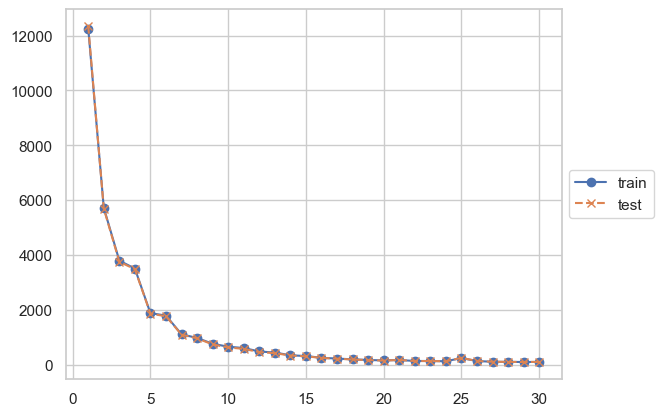

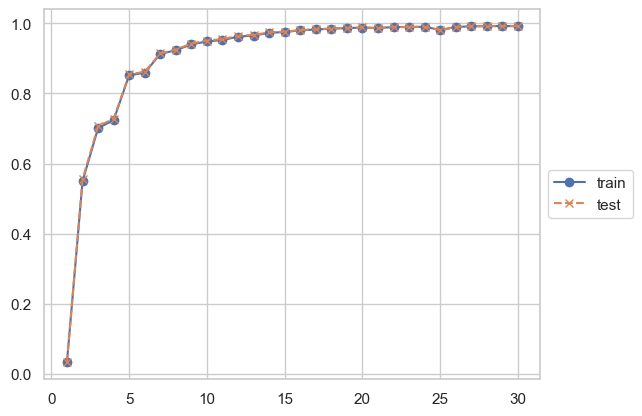

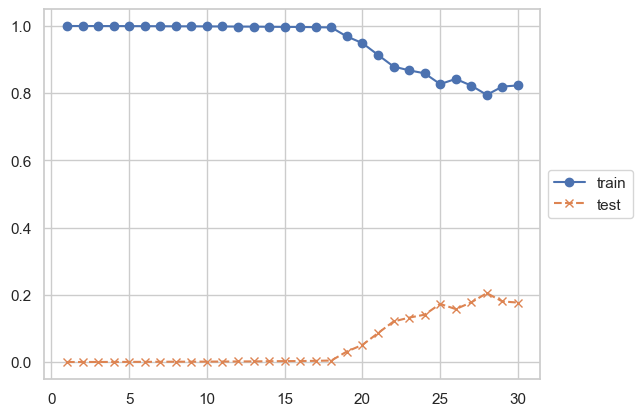

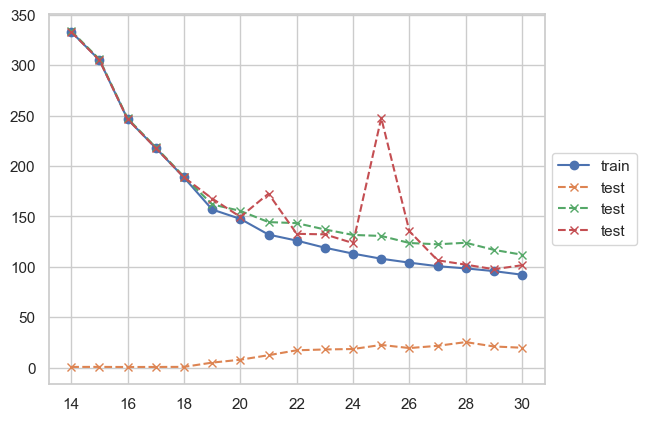

In [16]:
# Plotting MSE and R2 against complexity
plt.plot(N[1:], MSE_train, 'o-', label='train')
plt.plot(N[1:], MSE_test, 'x--', label='test')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True)
plt.show()

plt.plot(N[1:],R2_train, 'o-', label='train')
plt.plot(N[1:],R2_test, 'x--', label='test')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True)
plt.show()

plt.plot(N[1:], bias / error, 'o-', label='train')
plt.plot(N[1:], variance / error, 'x--', label='test')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True)
plt.show()

plt.plot(N[14:], bias[13:], 'o-', label='train')
plt.plot(N[14:], variance[13:], 'x--', label='test')
plt.plot(N[14:], error[13:], 'x--', label='test')
plt.plot(N[14:], MSE_test[13:], 'x--', label='test')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True)
plt.show()

In [17]:
z_total = pipeline.predict(X)

x_plot = x.reshape((n,n))
y_plot = y.reshape((n,n))
z_plot = z_total.reshape((n,n))

z_orig_plot = z.reshape((n,n))

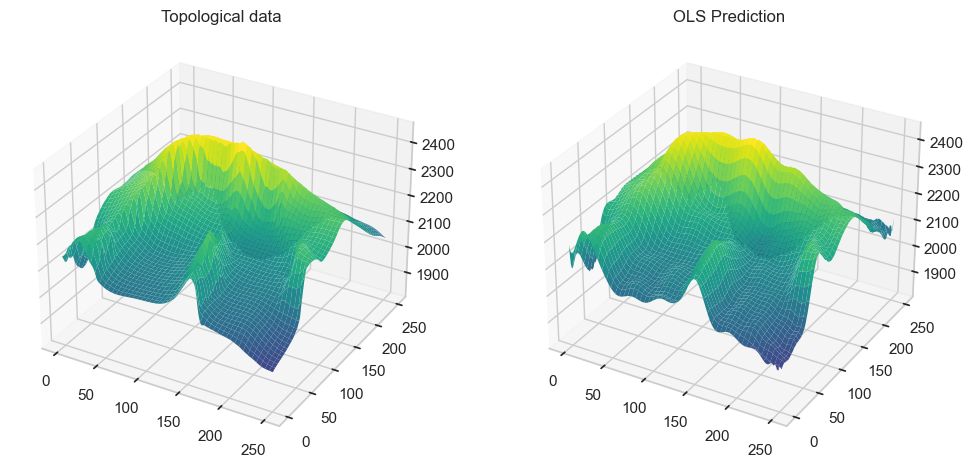

In [18]:
fig = plt.figure(figsize=(12, 6))

# Plotting the datapoints
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x_plot, y_plot, z_orig_plot, cmap='viridis', edgecolor='none')
ax.set_title('Topological data')

# Plot the polynomial regression prediction (ideally a plane)
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x_plot, y_plot, z_plot, cmap='viridis', edgecolor='none')
ax.set_title('OLS Prediction')

plt.show()

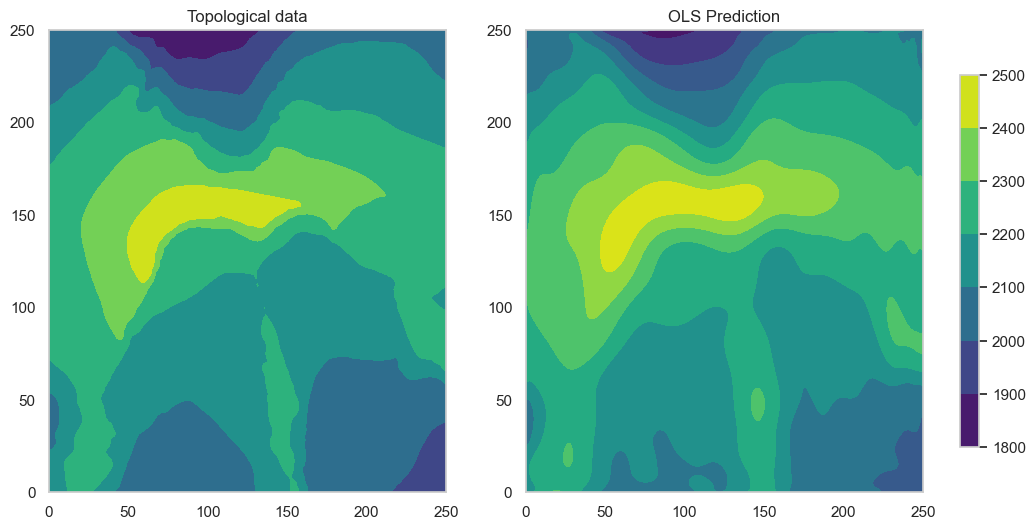

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the datapoints
original_data = axs[0].contourf(x_plot, y_plot, z_orig_plot, cmap='viridis')
axs[0].set_title('Topological data')

# Plot the polynomial regression prediction
fitted_data = axs[1].contourf(x_plot, y_plot, z_plot, cmap='viridis')
axs[1].set_title('OLS Prediction')


# Create the colorbar
contourf_objects = [original_data, fitted_data]
fig.colorbar(contourf_objects[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

plt.show()